In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('housing_price_dataset.csv')
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [4]:
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [6]:
df.drop('Price', axis=1).duplicated().sum()

231

In [7]:
df[df.drop('Price', axis=1).duplicated()]

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
1788,2279,3,1,Suburb,1987,255372.759505
4088,1163,3,3,Rural,2011,149155.712825
4261,2652,4,1,Urban,1978,247417.343144
5349,2594,4,1,Urban,1984,338286.101089
5666,2349,4,2,Rural,1954,200584.624684
...,...,...,...,...,...,...
49649,2232,4,3,Rural,1992,269408.288160
49785,2690,3,3,Urban,2013,199486.626754
49806,2560,3,1,Rural,2007,288672.220625
49921,1174,5,2,Suburb,1962,106386.439508


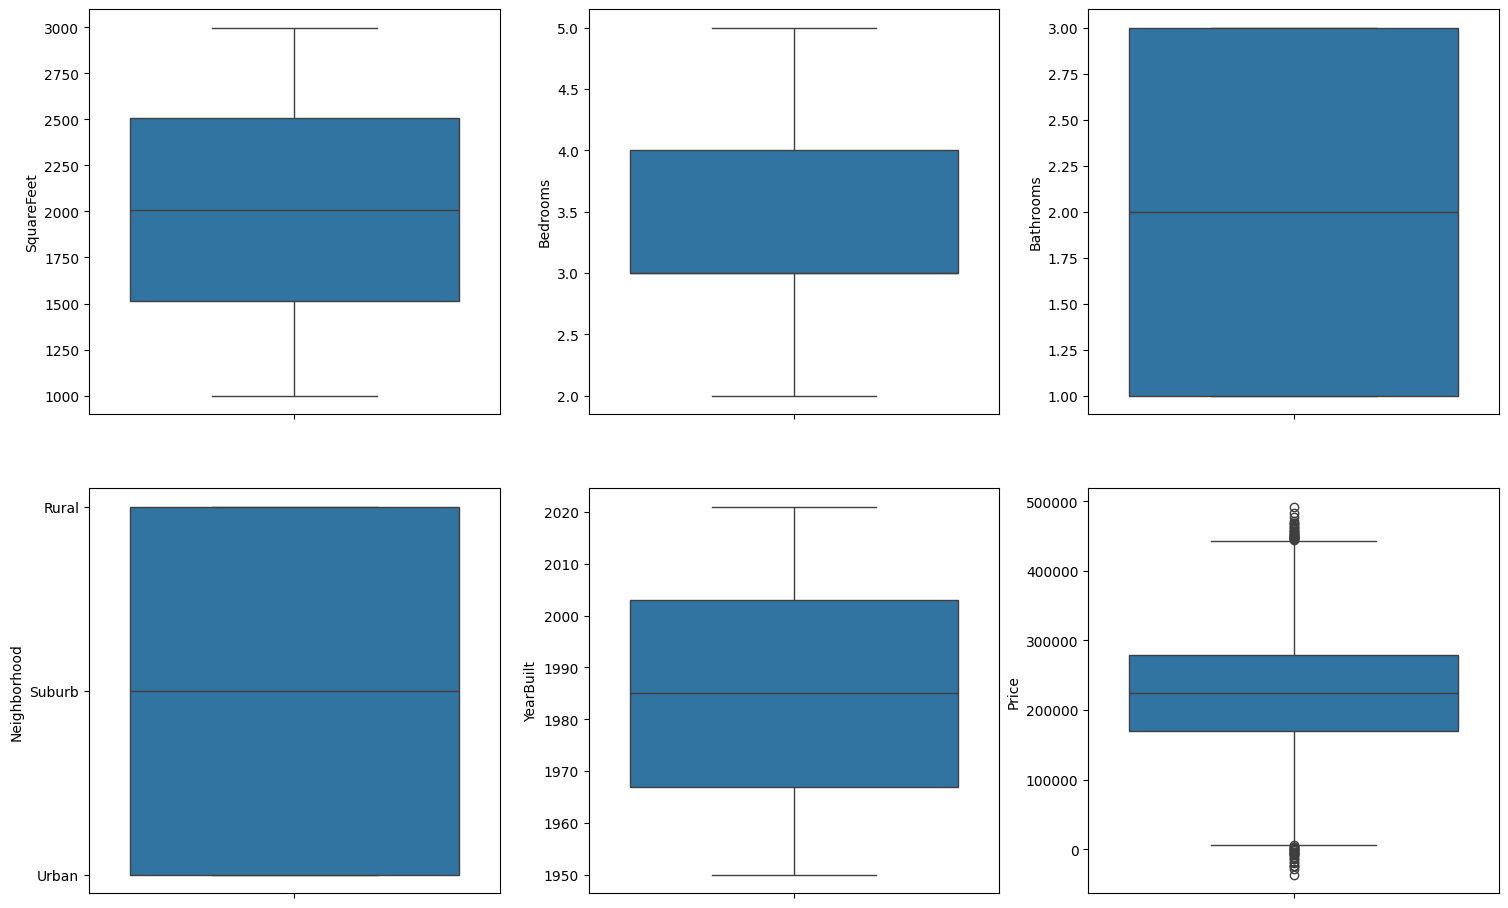

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 9))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [6]:
df_ = df.copy()
df_ = df.drop("Neighborhood", axis=1)
for k, v in df_.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df_)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column SquareFeet outliers = 0.00%
Column Bedrooms outliers = 0.00%
Column Bathrooms outliers = 0.00%
Column YearBuilt outliers = 0.00%
Column Price outliers = 0.12%


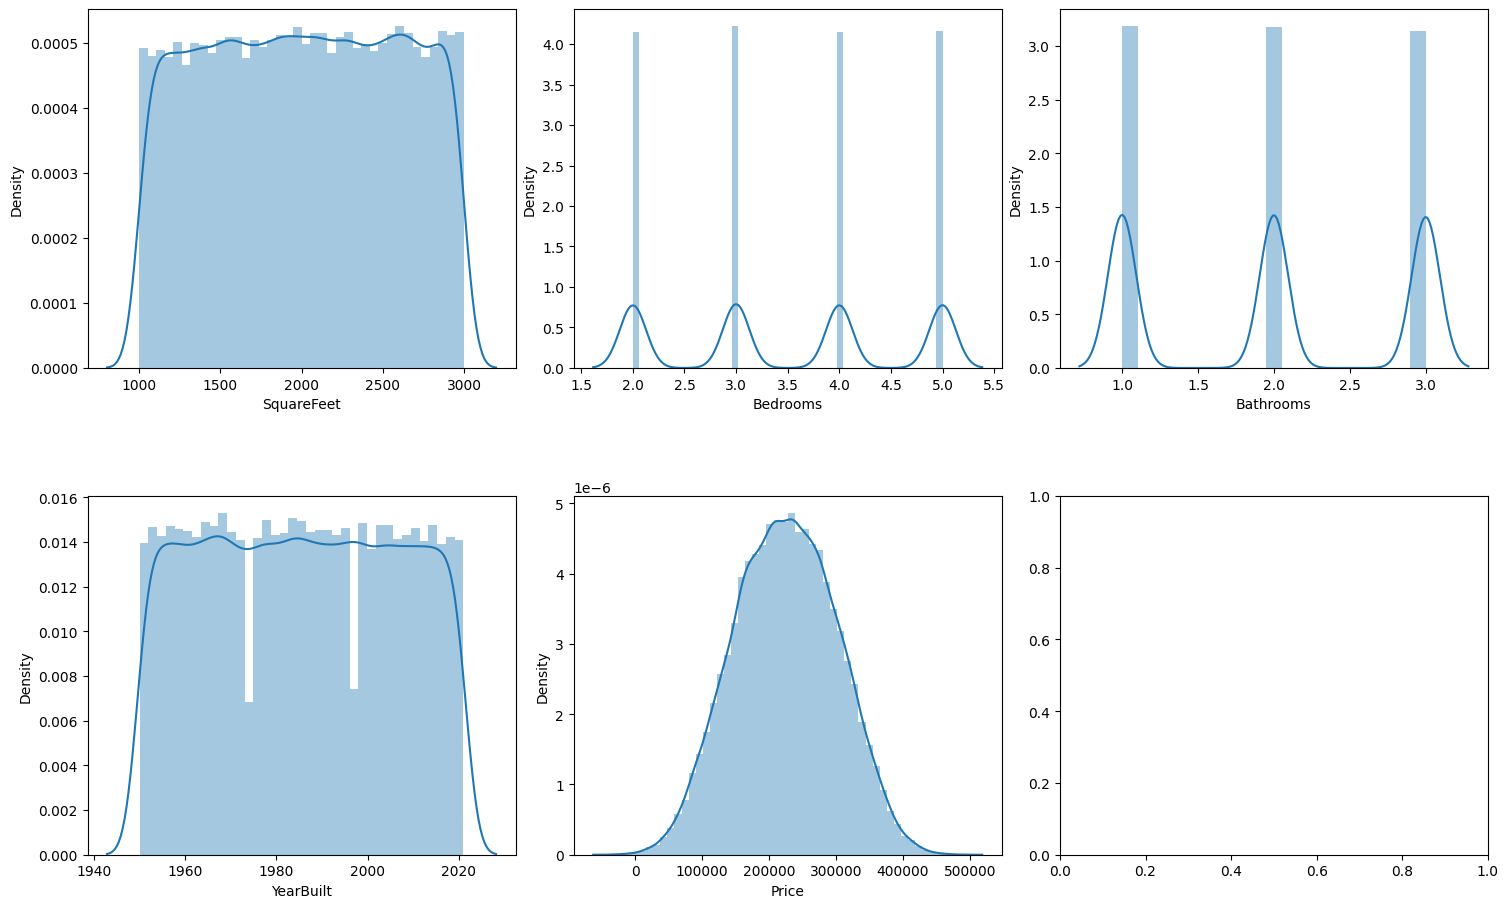

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 9))
index = 0
axs = axs.flatten()
for k,v in df_.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [8]:
one_hot = pd.get_dummies(df, columns=['Neighborhood'])
one_hot

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban
0,2126,4,1,1969,215355.283618,True,False,False
1,2459,3,2,1980,195014.221626,True,False,False
2,1860,2,1,1970,306891.012076,False,True,False
3,2294,2,1,1996,206786.787153,False,False,True
4,2130,5,2,2001,272436.239065,False,True,False
...,...,...,...,...,...,...,...,...
49995,1282,5,3,1975,100080.865895,True,False,False
49996,2854,2,2,1988,374507.656727,False,True,False
49997,2979,5,3,1962,384110.555590,False,True,False
49998,2596,5,2,1984,380512.685957,True,False,False


In [9]:
X = one_hot.drop("Price", axis=1)
y = one_hot['Price']

In [10]:
X.columns

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt',
       'Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban'],
      dtype='object')

In [11]:
scaler = MinMaxScaler()
scaler.fit(X)

X_scale = scaler.transform(X)
X_scale

array([[0.56328164, 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.72986493, 0.33333333, 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.43021511, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.989995  , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.7983992 , 1.        , 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.28614307, 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [17]:
scaler.get_feature_names_out()

array(['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt',
       'Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban'],
      dtype=object)

In [11]:
X_scale_ = pd.DataFrame(X_scale, columns=X.columns)
X_scale_.head()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban
0,0.563282,0.666667,0.0,0.267606,1.0,0.0,0.0
1,0.729865,0.333333,0.5,0.422535,1.0,0.0,0.0
2,0.430215,0.000000,0.0,0.281690,0.0,1.0,0.0
3,0.647324,0.000000,0.0,0.647887,0.0,0.0,1.0
4,0.565283,1.000000,0.5,0.718310,0.0,1.0,0.0


In [12]:
data = pd.concat([X_scale_, y], axis=1)
data.head()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban,Price
0,0.563282,0.666667,0.0,0.267606,1.0,0.0,0.0,215355.283618
1,0.729865,0.333333,0.5,0.422535,1.0,0.0,0.0,195014.221626
2,0.430215,0.000000,0.0,0.281690,0.0,1.0,0.0,306891.012076
3,0.647324,0.000000,0.0,0.647887,0.0,0.0,1.0,206786.787153
4,0.565283,1.000000,0.5,0.718310,0.0,1.0,0.0,272436.239065


<Axes: >

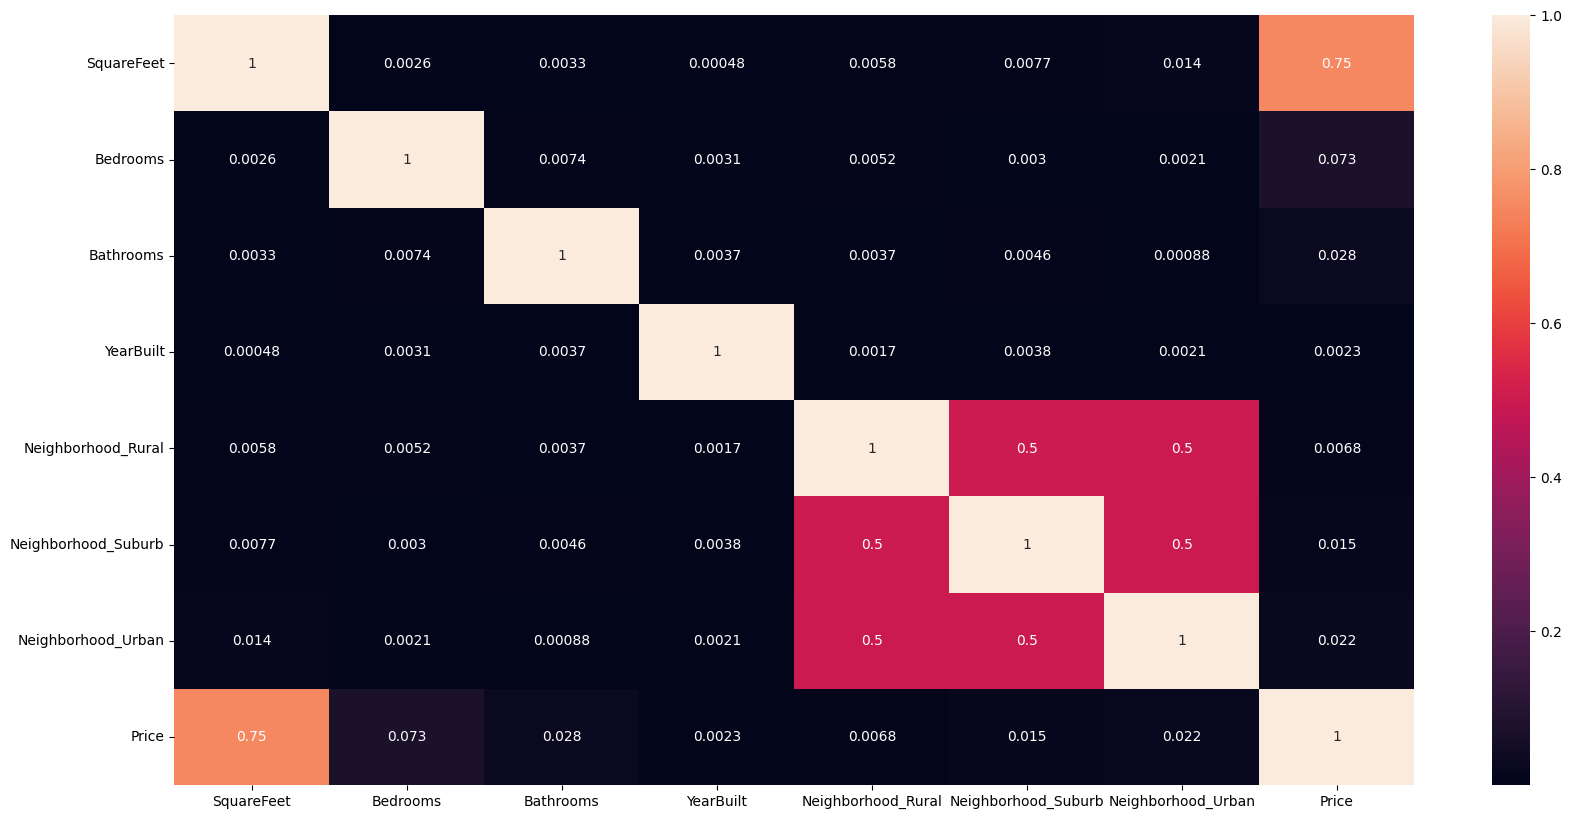

In [13]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scale_, y, test_size=.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 7) (40000,)
(10000, 7) (10000,)


In [15]:
# scores_map = {}

In [16]:
# kf = KFold(n_splits=10)

# XGB

In [17]:
params_XGB_best ={'n_estimators': 2565,
 'learning_rate': 0.09732287808197748,
 'max_depth': 6,
 'min_child_weight': 0.007737991528812258,
 'subsample': 0.1,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.9,
 'gamma': 1.3007598689577686,
 'reg_lambda': 9.683728618282095e-06,
 'reg_alpha': 0.08617584406570492}

XGBRegressor_model = XGBRegressor(**params_XGB_best,objective='reg:absoluteerror').fit(X_train,y_train)
cv_XGBoost = cross_val_score(estimator = XGBRegressor_model, X = X_train, y = y_train, cv = 5)
y_pred_XGBoost_test = XGBRegressor_model.predict(X_test)
r2_score_XGBoost_test = r2_score(y_test, y_pred_XGBoost_test)
print("CV: ", cv_XGBoost.mean())
print('R2_score (eval): ', r2_score_XGBoost_test)

CV:  0.45881348542705747
R2_score (eval):  0.48054848802129413


# LightGBM

In [18]:
params_LGBM_best ={'n_estimators': 2309,
 'learning_rate': 0.04942932762026841,
 'max_depth': 6,
 'min_child_weight': 0.21030657642741743,
 'subsample': 0.30000000000000004,
 'colsample_bytree': 0.775,
 'reg_lambda': 0.21539132638034386,
 'reg_alpha': 2.5398950960373498e-08}

LGBM_model = LGBMRegressor(**params_LGBM_best,objective='regression_l1').fit(X_train,y_train)
cv_LGBM = cross_val_score(estimator = LGBM_model, X = X_train, y = y_train, cv = 5)
y_pred_LGBM_test = LGBM_model.predict(X_test)
r2_score_LGBM_test = r2_score(y_test, y_pred_LGBM_test)
print("CV: ", cv_LGBM.mean())
print('R2_score (eval): ', r2_score_LGBM_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 7
[LightGBM] [Info] Start training from score 225097.078125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [19]:
models = [('XGB', r2_score_XGBoost_test, cv_XGBoost.mean()),
        ( 'LGBM', r2_score_LGBM_test, cv_LGBM.mean())
         ]                                          


predict = pd.DataFrame(data = models, columns=['Model', 'R2_Score(eval)', 'Cross-Validation'])
predict

,Model,R2_Score(eval),Cross-Validation
0,XGB,0.480548,0.458813
1,LGBM,0.558753,0.547790


In [22]:
predict_XGB = XGBRegressor_model.predict(X_test)
predict_LGBM = LGBM_model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [23]:
pd.DataFrame({
    'y_test':y_test,
    'predict_XGB':predict_XGB,
    'predict_LGBM':predict_LGBM
})

,y_test,predict_XGB,predict_LGBM
33553,170835.035713,200515.406250,211069.931458
9427,126913.469998,61083.101562,153661.386231
199,246611.883092,260886.765625,258295.053803
12447,244250.462969,242119.562500,257956.164719
39489,271127.650112,264382.156250,279846.531549
...,...,...,...
28567,199265.817701,221188.437500,226119.659949
25079,241869.621812,185273.734375,194603.827659
18707,352184.123976,318820.406250,317967.933550
15200,244830.805238,204236.140625,201971.027358


In [24]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "housing_price_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(LGBM_model, file)

In [25]:
scale_pkl_file = "scaler.pkl"  

with open('scaler_model.pkl', 'wb') as scale:
    pickle.dump(scaler, scale)